In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import random
import iqpopt as iqp
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic
import jax
import jax.numpy as jnp

# Parameterized IQP circuits  training with Latent Representation of Datasets

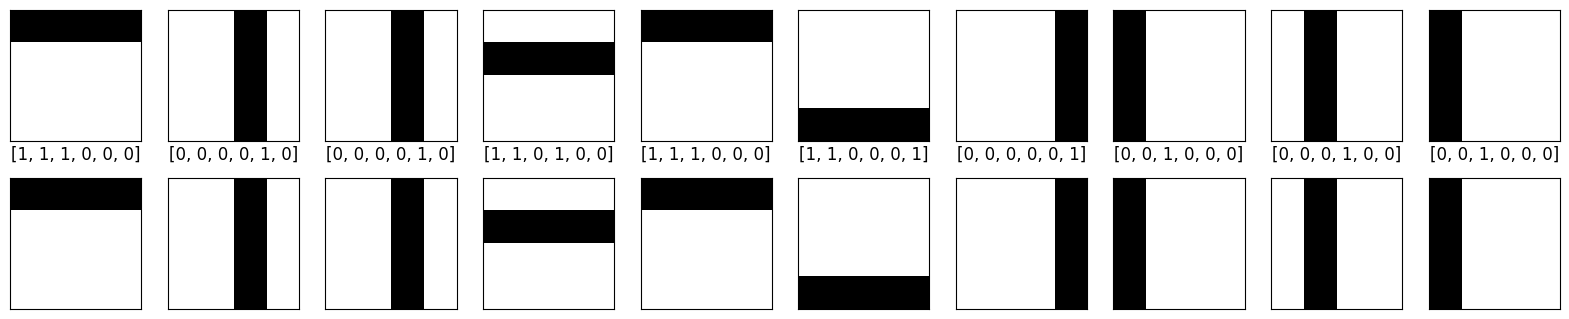

In [172]:
def label_simple_bars_stripes(size):
    type_choice = np.random.choice(['bars','stripes'])
    pattern = np.zeros((size,size))
    place = np.random.choice([0,1,2,3])
    if type_choice == 'bars':
        label = int(0)
        pattern[:,place] = np.ones(4)
    elif type_choice == 'stripes':
        label = int(1)
        pattern[place,:] = np.ones(4)
    return [label] + np.concatenate(pattern).astype(int).tolist()

def encode_BarsStripes(pattern):
    '''Pattern 4x4 to vector (type + position of bars/stripe)'''
    
    #Primer elemento es la label
    label = pattern[0]
    #Tomar patron del bar/stripe
    im = np.reshape(pattern[1:], [4, 4])
    if label == 0:
        patron = im[0,:]
    elif label == 1:
        patron = im[:,0]
    patron = patron.tolist()
    return [label] + [label] + patron

def decode_BarsStripes(vector):
    patron = vector[2:]
    if vector[1] == 0:
        rec = np.tile(patron, (4, 1))
    elif vector[1] == 1:
        rec = np.repeat(np.array(patron).reshape(-1, 1),4, axis=1)
    return rec
        


#Generamos dataset y set para comparacion posterior
label_ctrain = [] 
latent_train = []
bar = set()
stripe = set() 
for k in range(5000):
    pattern = label_simple_bars_stripes(4)
    label_ctrain.append(pattern)
    latent_train.append(encode_BarsStripes(pattern))
    string = ''.join(map(str,pattern[1:]))
    if pattern[0] == 1:
        stripe.add(string)
    elif pattern[0] == 0:
        bar.add(string)


n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    im = label_ctrain[i]
    en = encode_BarsStripes(label_ctrain[i])
    de = decode_BarsStripes(en)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(np.reshape(im[1:], [4, 4]), cmap="gray_r")
    ax.text(0.5, -0.1, str(en), ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.reshape(de, [4, 4]), cmap="gray_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



In [213]:
#Circuito IQP condicionado
n_qubits = 6  
depth = 17

gates = []
for d in range(depth):
    gates.append([[0,1]])
    for k in range(n_qubits-2):
        gates.append([[k+2]])
        gates.append([[1,k+2]])
        #gates.append([[1,k+2],[k+2]])
        #gates.append([[1],[k+2]])
    
    

circ = iqp.IqpSimulator(n_qubits,gates,device ='lightning.qubit')

1.4142135623730951


Training Progress: 100%|██████████| 700/700 [02:28<00:00,  4.73it/s, loss=0.003685, elapsed time=0.21, total time=149] 

Training has not converged after 700 steps


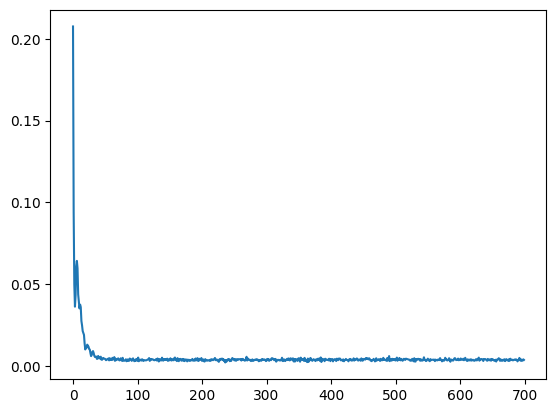

In [214]:
#Train
sigma = median_heuristic(latent_train) #Parametro para la MMD_loss
print(sigma)
loss = genq.mmd_loss_iqp


#Entrenar circuito
key = jax.random.PRNGKey(42)

params_init = jax.random.normal(key, (len(gates),)) * (1 / jnp.sqrt(n_qubits))
#params_init = jnp.ones(len(simple_gates)) *  (1 / jnp.sqrt(n_qubits))

loss_kwarg = {
    "params": params_init,
    "iqp_circuit": circ,
    "ground_truth": jnp.array(latent_train), # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 2000,
    "n_samples": 2000,
    "key": jax.random.PRNGKey(42),}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters= 700,loss_kwargs=loss_kwarg)
trained_params = trainer.final_params
plt.plot(trainer.losses)
plt.show()     

Porcentaje de decisión correcta:61.224489795918366 %
Porcentaje de correctas: 42.857142857142854 %


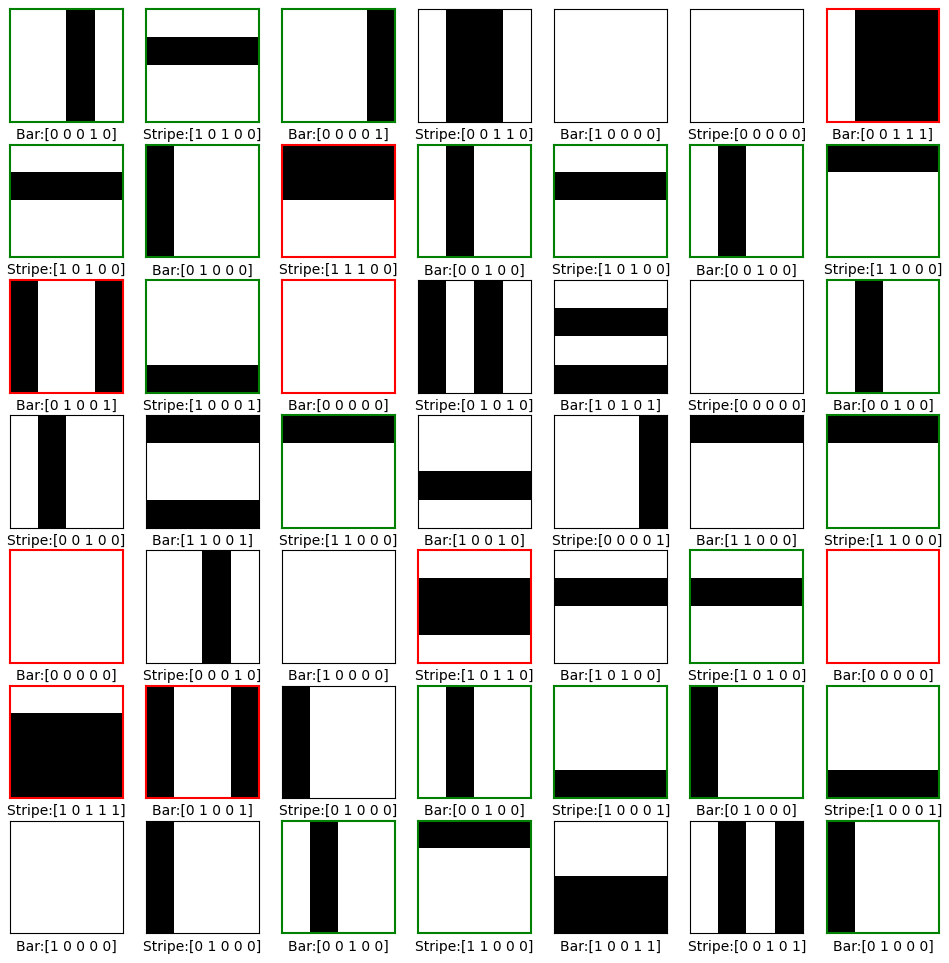

In [215]:

#Plots de resultados
j = 1
rcount = 0
gcount = 0
plt.figure(figsize=[12, 12])
for k in range(49):
    check1 = False
    check2 = False
    if k % 2 == 0:
        data = circ.sample(trained_params,shots = 1)
        im = decode_BarsStripes(data)
        tipo = 'Bar'
        if data[1] == 0:
            check1 = True


    elif k % 2 == 1:
        circ2 = iqp.IqpSimulator(n_qubits,gates,init_gates=[[[0]]],init_coefs=[np.pi], device ='lightning.qubit')
        data = circ2.sample(trained_params,shots = 1)
        im = decode_BarsStripes(data)
        tipo = 'Stripe'
        if data[1] == 1:
            check1 = True


    if sum(data[2:])== 1:
        check2 = True
    
    ax = plt.subplot(7, 7, j)
    j += 1
    plt.imshow(np.reshape(im, [4, 4]), cmap="gray_r")
    ax.set_xlabel(f'{tipo}:{data[1:]}')
    if check1 == True:
        rcount += 1
        if check2 == False:
            plt.setp(ax.spines.values(), color="red", linewidth=1.5)
        elif check2 == True:
            gcount += 1
            plt.setp(ax.spines.values(), color="green", linewidth=1.5)
    plt.xticks([])
    plt.yticks([])

print(f'Porcentaje de decisión correcta:{rcount/49 * 100} %')
print(f'Porcentaje de correctas: {gcount/49* 100} %')

In [216]:
#Estimacion precision#Plots de resultados
j = 1
rcount = 0
gcount = 0
for k in range(1000):
    check1 = False
    check2 = False
    if k % 2 == 0:
        data = circ.sample(trained_params,shots = 1)
        if data[1] == 0:
            check1 = True


    elif k % 2 == 1:
        circ2 = iqp.IqpSimulator(n_qubits,gates,init_gates=[[[0]]],init_coefs=[np.pi], device ='lightning.qubit')
        data = circ2.sample(trained_params,shots = 1)
        if data[1] == 1:
            check1 = True
            
    if sum(data[2:])== 1:
        check2 = True
    if check1 == True:
        rcount += 1
        if check2 == True:
            gcount += 1
            

print(f'Porcentaje de decisión correcta:{rcount/10} %')
print(f'Porcentaje de correctas: {gcount/10} %')
    

Porcentaje de decisión correcta:50.3 %
Porcentaje de correctas: 24.0 %
